# (phase 1) 03 Class overlap mitigation

Once the overlapping regions and/or instances have been accurately identified, it is possible to try to mitigate its impact on the performance. To do so, there are three (two) approaches implemented in this study:

- 1. Discarding scheme (not implemented)
- 2. Separating scheme 
- 3. Merging scheme

## Load data and packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform
from mpl_toolkits.mplot3d import Axes3D
import gower
import prince
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, recall_score, roc_auc_score, roc_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from collections import Counter
from typing import List
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline
from tqdm import tqdm
from scipy.spatial.distance import euclidean, hamming
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import BallTree
from sklearn.neighbors import KernelDensity
from sklearn.neighbors import NearestNeighbors
from joblib import dump, load
import scipy.stats

# import from custom package
from auxFuns.EDA import *
from auxFuns.modelling import *
from auxFuns.class_overlap import *

In [2]:
import auxFuns.EDA 
importlib.reload(auxFuns.EDA)

import auxFuns.modelling
importlib.reload(auxFuns.modelling)

import auxFuns.class_overlap
importlib.reload(auxFuns.class_overlap)

<module 'auxFuns.class_overlap' from 'c:\\Users\\angel\\Documents\\VSCode\\rsv_modelling_transfer_learning\\auxFuns\\class_overlap.py'>

In [3]:
# Load phase 1 data
raw_datasets_path = os.getcwd() + '/datasets/raw'
processed_datasets_path = os.getcwd() + '/datasets/processed'

# Phase 1 data
rsv_predictors_df_v2 = pd.read_csv(processed_datasets_path + '/rsv_predictors_phase1_daysDedup_seasons_prevTest_v2.csv',low_memory=False)
rsv_predictors_phase1_df = make_it_categorical_v2(rsv_predictors_df_v2)

# Following the model selection step, these are the final features taken for modelling
selected_features_v2 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'key_comorbidities','Pneumonia',
                     'season','month_of_the_test','multiple_tests',
                     'BPA','BPAI']
selected_features_v2.append('RSV_test_result')

df_modelling_phase1 = rsv_predictors_phase1_df[selected_features_v2]

df_modelling_phase1.shape

(86058, 21)

In [15]:
X = df_modelling_phase1.drop(['RSV_test_result'], axis = 1)
y = df_modelling_phase1.RSV_test_result

random_seed = 42

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_seed)

In [11]:
X_train.shape, X_test.shape, y_train.value_counts(), y_test.value_counts()

((68846, 20),
 (17212, 20),
 Negative    66723
 Positive     2123
 Name: RSV_test_result, dtype: int64,
 Negative    16681
 Positive      531
 Name: RSV_test_result, dtype: int64)

## 1. Separating scheme
- Identify overlapping and non overlapping regions using the n1 approach
- Fit models independently
- Evaluate the models independently


In [13]:
# 1.1. Identify overlapping and non overlapping regions using n1 approach
X_all = pd.get_dummies(pd.concat([X_train, X_validation], axis = 0))
labels_all = pd.concat([y_train,y_validation], axis = 0)

same_class_neighbours_dict, N1_metric_dict, dist_matrix, ind = calculate_same_neighbours_and_N1(X = X_all, y = labels_all, n_neighbours = 2)


Build-up of the ball tree ...
Finding closest 1 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.052185735201840666
Done!


In [16]:
len_train = X_train.shape[0]
len_validation = X_validation.shape[0]

same_class_neighbours_dict_training = {key: value[:len_train] for key, value in same_class_neighbours_dict.items()}
same_class_neighbours_dict_validation = {key: value[-len_validation:] for key, value in same_class_neighbours_dict.items()}

In [17]:
# 1.2. Fit of TWO independent models (one in the overlapping and one in the non-overlapping regions) in the TRAINING SET
print('\n------------------')
print('-------------------')
n_neighbours_to_determine_overlap = 1
print('Fitting model on trainig data exclusively')
print(f'Building the two models using as reference {n_neighbours_to_determine_overlap} number of neighbours to determine overlap')

overlapping_mask_training = ~same_class_neighbours_dict_training[n_neighbours_to_determine_overlap]

model_nonOverlapping, model_Overlapping = only_build_2overlapping_models(X = X_train, labels = y_train, is_overlapping = overlapping_mask_training, 
                                                                        random_seed = 42,
                                                                        model_class_non_overlapping = RandomForestClassifier(),
                                                                        param_grid_non_overlapping = {'n_estimators': [7, 14],'max_depth': [10, 20],'min_samples_split': [5, 10],'min_samples_leaf': [1, 4]},
                                                                        cost_sensitive_non_overlapping = False, weight_dict_non_overlapping = {'Negative': 1, 'Positive': 15},
                                                                        model_class_overlapping = RandomForestClassifier(),
                                                                        param_grid_overlapping = {'n_estimators': [7, 14],'max_depth': [10, 20],'min_samples_split': [5, 10],'min_samples_leaf': [1, 4]},
                                                                        cost_sensitive_overlapping = False, weight_dict_overlapping = {'Negative': 1, 'Positive': 15})


------------------
-------------------
Fitting model on trainig data exclusively
Building the two models using as reference 1 number of neighbours to determine overlap
----------------
Building non-overlapping model ...
Training model ... RandomForestClassifier(random_state=42)
Best training parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 7}
Best training f1-score:  0.5882358744089888
----------------
Building (yes) overlapping model ...
Training model ... RandomForestClassifier(random_state=42)
Best training parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 7}
Best training f1-score:  0.49500369646003717


In [20]:
## Probs in the validation setting
X_validation_dummies = pd.get_dummies(X_validation)

y_probs_validation_nonOverlapping_model = model_nonOverlapping.predict_proba(X_validation_dummies)[:,1]

y_probs_validation_Overlapping_model = model_Overlapping.predict_proba(X_validation_dummies)[:,1]

Optimal threshold: 0.3
Optimal f1: 0.6023102310231023


AUC Score: 0.9082639777249193
Precision / Positive predictive value: 0.5359765051395007
Specificity: 0.9810562915892332
Recall / sensitivity: 0.687382297551789
Negative predictive value: 0.9899582602383401
Accuracy: 0.9719962816639554
F-1: 0.6023102310231023
Precision-Recall AUC: 0.5953295024704534


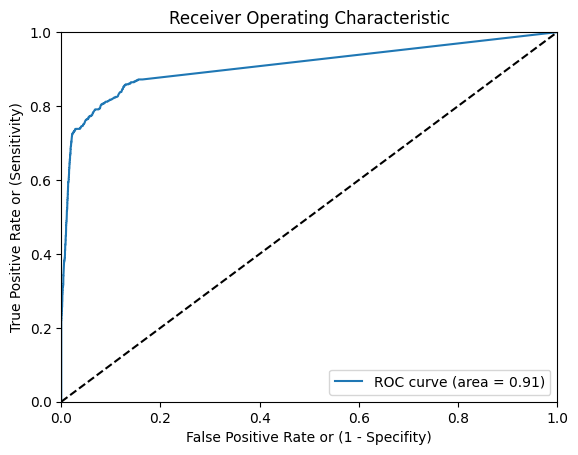

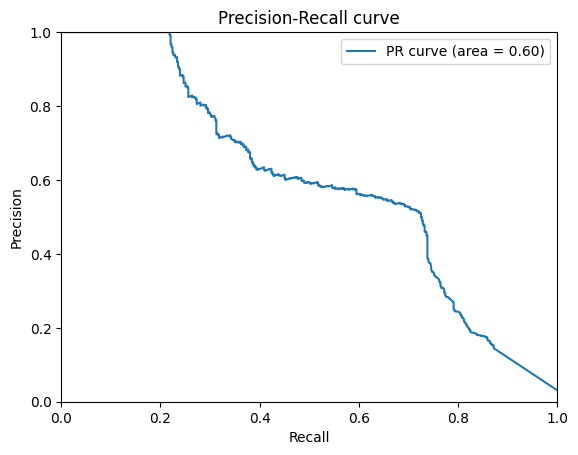

In [21]:
## 1.3. Evaluate the model
### Aggregated model
true_overlapping_mask = ~same_class_neighbours_dict_validation[1]

y_probs_all = (true_overlapping_mask * y_probs_validation_Overlapping_model) + ((~true_overlapping_mask) * y_probs_validation_nonOverlapping_model)

optimal_threshold = find_optimal_moving_threshold_from_probas(y_probs=y_probs_all, y_test=y_validation, verbose = True)

__, __, __, __, __, __, f1, __ = calculate_performance_metrics_from_probas(y_probs = y_probs_all, y_test = y_validation, 
                                                                    threshold= optimal_threshold, print_roc = True, print_pr = True, verbose = True)


In [26]:
# Performance of OVERLAPPING model
y_probs_overlapping = y_probs_all[true_overlapping_mask]
y_validation_overlapping = y_validation[true_overlapping_mask]

optimal_threshold = find_optimal_moving_threshold_from_probas(y_probs=y_probs_overlapping, y_test=y_validation_overlapping, verbose = True)

__, __, __, __, __, __, f1, __ = calculate_performance_metrics_from_probas(y_probs = y_probs_overlapping, y_test = y_validation_overlapping, 
                                                                    threshold= optimal_threshold, print_roc = False, print_pr = False, verbose = True)

Optimal threshold: 0.24
Optimal f1: 0.6378035902851108


AUC Score: 0.7412701717269475
Precision / Positive predictive value: 0.47709320695102686
Specificity: 0.41519434628975266
Recall / sensitivity: 0.9617834394904459
Negative predictive value: 0.951417004048583
Accuracy: 0.6102272727272727
F-1: 0.6378035902851108
Precision-Recall AUC: 0.6109257344382144


In [27]:
# Performance of non-overlapping model
y_probs_nonOverlapping = y_probs_all[~true_overlapping_mask]
y_validation_nonOverlapping = y_validation[~true_overlapping_mask]

optimal_threshold = find_optimal_moving_threshold_from_probas(y_probs=y_probs_nonOverlapping, y_test=y_validation_nonOverlapping, verbose = True)

__, __, __, __, __, __, f1, __ = calculate_performance_metrics_from_probas(y_probs = y_probs_nonOverlapping, y_test = y_validation_nonOverlapping, 
                                                                    threshold= optimal_threshold, print_roc = False, print_pr = False, verbose = True)

Optimal threshold: 0.71
Optimal f1: 0.5238095238095238


AUC Score: 0.8035703919552868
Precision / Positive predictive value: 1.0
Specificity: 1.0
Recall / sensitivity: 0.3548387096774194
Negative predictive value: 0.9913872654567826
Accuracy: 0.9914278716629928
F-1: 0.5238095238095238
Precision-Recall AUC: 0.42908945018187755


In [36]:
# Performance of the aggregated model
pred_nonOverlapping = ['Positive' if lab == True else 'Negative' for lab in (y_probs_nonOverlapping > 0.71)] # these are the optimal thresholds identified previously
pred_overlapping = ['Positive' if lab == True else 'Negative' for lab in (y_probs_overlapping > 0.24)]

pred = pred_nonOverlapping + pred_overlapping
y_probs = np.concatenate([y_probs_nonOverlapping, y_probs_overlapping])
true = pd.concat([y_validation_nonOverlapping, y_validation_overlapping], axis = 0)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true, pred)
precision = precision_score(true, pred, pos_label = 'Positive')
recall = recall_score(true, pred, pos_label = 'Positive')
f1 = f1_score(true, pred, pos_label = 'Positive')
roc_auc = roc_auc_score(true, y_probs)
spec = specificity(true, pred)
npv = negative_predictive_value(true, pred)
precision_curve, recall_curve, _ = precision_recall_curve(true, y_probs, pos_label = 'Positive')
pr_auc = auc(recall_curve, precision_curve)

print('\n-------')
print('Performance metrics of the aggregated model')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall/Sensitivity: {recall}")
print(f"F1-score: {f1}")
print(f"ROC AUC: {roc_auc}")
print(f"Specificity: {spec}")
print(f"Negative Predictive Value: {npv}")
print(f"Precision-Recall AUC: {pr_auc}")


-------
Performance metrics of the aggregated model
Accuracy: 0.9719381826632582
Precision: 0.5338028169014084
Recall/Sensitivity: 0.7137476459510358
F1-score: 0.6107977437550361
ROC AUC: 0.9082639777249193
Specificity: 0.9801570649241652
Negative Predictive Value: 0.9907889952733002
Precision-Recall AUC: 0.5953295024704534
